# Importing Libs and Data

In [53]:
import os
import PIL
import math
import random
import shutil
import tqdm

import tensorflow as tf
import numpy as np
import pandas as pd
from sklearnex import patch_sklearn
patch_sklearn()

import sklearn
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

import visualkeras

import keras
from keras import Sequential
from keras.layers import Dense, Rescaling, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.layers import RandomFlip, RandomContrast, RandomZoom, RandomRotation, Resizing
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.wrappers.scikit_learn import KerasClassifier

print(tf.config.list_physical_devices())

seed = 42

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
def create_or_fetch_data(fp, force_remake=False):
    name = fp[2:]
    if os.path.exists(f'{fp}/{name}.csv') and not force_remake:
        data = pd.read_csv(f'{fp}/{name}.csv')
    else:
        files = {'filename':[], 'label':[],'img':[]}
        with os.scandir(fp) as dir:
            for entry in dir:
                if entry.name == f'{name}.csv':
                    continue
                with os.scandir(f'{fp}/{entry.name}') as folder:
                    for img in folder:
                        # print(img.name)
                        files['filename'].append(img.name)
                        files['label'].append(entry.name)
                        files['img'].append(tf.keras.utils.img_to_array(tf.keras.utils.load_img(f"{fp}/{entry.name}/{img.name}", color_mode='grayscale')))

        data = pd.DataFrame(files)[files.keys()]
        data.to_csv(f'{fp}/{name}.csv', index=False)

    display(data)
    return data


train = create_or_fetch_data('./train', force_remake=True)
test = create_or_fetch_data('./test', force_remake=True)
validation = create_or_fetch_data('./validation', force_remake=True)

,filename,label,img
0,0026.jpg,Bean,"[[[184.0], [184.0], [185.0], [185.0], [185.0],..."
1,0028.jpg,Bean,"[[[87.0], [86.0], [83.0], [86.0], [95.0], [101..."
2,0029.jpg,Bean,"[[[216.0], [217.0], [219.0], [220.0], [220.0],..."
3,0030.jpg,Bean,"[[[173.0], [174.0], [175.0], [177.0], [178.0],..."
4,0034.jpg,Bean,"[[[172.0], [172.0], [172.0], [173.0], [173.0],..."
...,...,...,...
9023,0996.jpg,Tomato,"[[[182.0], [181.0], [181.0], [181.0], [181.0],..."
9024,0997.jpg,Tomato,"[[[33.0], [28.0], [23.0], [25.0], [31.0], [36...."
9025,0998.jpg,Tomato,"[[[135.0], [137.0], [138.0], [137.0], [135.0],..."
9026,0999.jpg,Tomato,"[[[143.0], [170.0], [155.0], [159.0], [155.0],..."


,filename,label,img
0,0001.jpg,Bean,"[[[61.0], [64.0], [67.0], [63.0], [44.0], [24...."
1,0002.jpg,Bean,"[[[93.0], [79.0], [54.0], [27.0], [15.0], [17...."
2,0003.jpg,Bean,"[[[134.0], [133.0], [132.0], [132.0], [133.0],..."
3,0004.jpg,Bean,"[[[156.0], [156.0], [156.0], [158.0], [161.0],..."
4,0005.jpg,Bean,"[[[132.0], [123.0], [104.0], [87.0], [83.0], [..."
...,...,...,...
2995,1196.jpg,Tomato,"[[[114.0], [113.0], [112.0], [112.0], [110.0],..."
2996,1197.jpg,Tomato,"[[[196.0], [210.0], [237.0], [215.0], [196.0],..."
2997,1198.jpg,Tomato,"[[[240.0], [220.0], [204.0], [214.0], [229.0],..."
2998,1199.jpg,Tomato,"[[[221.0], [230.0], [231.0], [221.0], [216.0],..."


,filename,label,img
0,0023.jpg,Bean,"[[[76.0], [66.0], [63.0], [71.0], [95.0], [96...."
1,0024.jpg,Bean,"[[[137.0], [140.0], [144.0], [145.0], [143.0],..."
2,0025.jpg,Bean,"[[[57.0], [58.0], [59.0], [60.0], [60.0], [60...."
3,0027.jpg,Bean,"[[[108.0], [102.0], [99.0], [96.0], [89.0], [8..."
4,0031.jpg,Bean,"[[[50.0], [48.0], [47.0], [46.0], [46.0], [45...."
...,...,...,...
2995,1396.jpg,Tomato,"[[[129.0], [133.0], [124.0], [117.0], [122.0],..."
2996,1397.jpg,Tomato,"[[[116.0], [107.0], [100.0], [101.0], [106.0],..."
2997,1398.jpg,Tomato,"[[[235.0], [237.0], [237.0], [235.0], [234.0],..."
2998,1399.jpg,Tomato,"[[[202.0], [200.0], [198.0], [197.0], [196.0],..."


In [3]:
vegtables = np.unique(train.label)
veg_count = {'veg':[],'train':[],'test':[],'validation':[]}
for veg in vegtables:
    veg_count['veg'].append(veg)
    veg_count['train'].append(len(train[train.label==veg]))
    veg_count['test'].append(len(test[test.label==veg]))
    veg_count['validation'].append(len(validation[validation.label==veg]))
    
veg_count = pd.DataFrame(veg_count)
veg_count

,veg,train,test,validation
0,Bean,780,200,200
1,Bitter_Gourd,720,200,200
2,Bottle_Gourd,441,200,200
3,Brinjal,868,200,200
4,Broccoli,750,200,200
5,Cabbage,503,200,200
6,Capsicum,351,200,200
7,Carrot,256,200,200
8,Cauliflower,587,200,200
9,Cucumber,812,200,200


In [4]:
classes = veg_count.veg
classes

0             Bean
1     Bitter_Gourd
2     Bottle_Gourd
3          Brinjal
4         Broccoli
5          Cabbage
6         Capsicum
7           Carrot
8      Cauliflower
9         Cucumber
10          Papaya
11          Potato
12         Pumpkin
13          Radish
14          Tomato
Name: veg, dtype: object

In [5]:
veg_count[['veg','train']].set_index('veg').T

veg,Bean,Bitter_Gourd,Bottle_Gourd,Brinjal,Broccoli,Cabbage,Capsicum,Carrot,Cauliflower,Cucumber,Papaya,Potato,Pumpkin,Radish,Tomato
train,780,720,441,868,750,503,351,256,587,812,566,377,814,248,955


C:\Users\linco\AppData\Local\Temp\ipykernel_20624\3473044687.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=temp.columns, x=temp.iloc[0], palette='pastel')


<Axes: xlabel='train', ylabel='veg'>

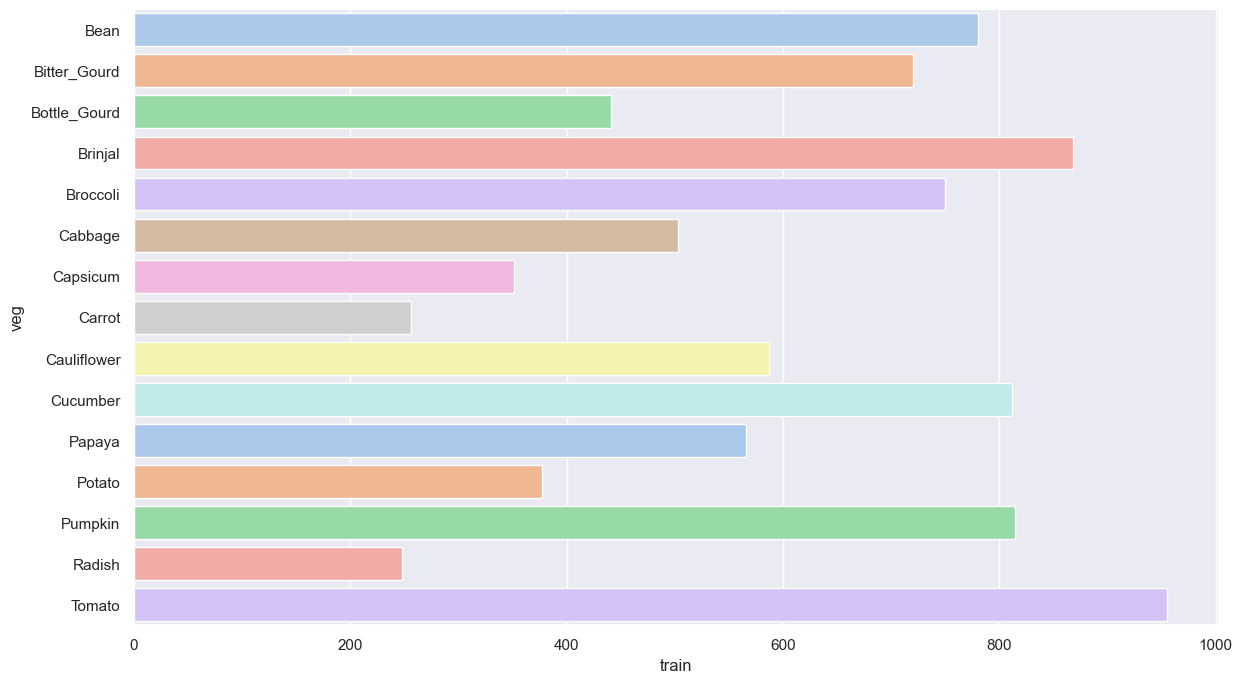

In [6]:
temp = veg_count[['veg','train']].set_index('veg').T
fig = plt.figure(figsize=(14,8))
sns.barplot(y=temp.columns, x=temp.iloc[0], palette='pastel')

In [7]:
veg_count.describe()

,train,test,validation
count,15.000000,15.0,15.0
mean,601.866667,200.0,200.0
std,231.118667,0.0,0.0
min,248.000000,200.0,200.0
25%,409.000000,200.0,200.0
50%,587.000000,200.0,200.0
75%,796.000000,200.0,200.0
max,955.000000,200.0,200.0


# Functions

In [8]:
def make_dataset(fp, img_size, batch_size):
    return tf.keras.utils.image_dataset_from_directory(
    directory=fp,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
    image_size=(img_size, img_size))

In [9]:
def create_aug_dataset(class_size, dataset, fp, img_size):
    data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.5),
    RandomZoom(0.5)
    ])

    resize = Resizing(img_size,img_size)

    if not os.path.exists(fp):
        os.mkdir(fp)

    if not os.path.exists(f'{fp}/{class_size}'):
        os.mkdir(f'{fp}/{class_size}')
        
        for veg in tqdm.tqdm(vegtables, desc='Checking & Creating Individual Folders'):
            path = f'{fp}/{class_size}/{veg}'
            if not os.path.exists(path):
                os.mkdir(path)
            elif len([1 for x in os.scandir(path)]) != class_size:
                shutil.rmtree(path, ignore_errors=True)
                os.mkdir(path)
                    
        for veg in tqdm.tqdm(vegtables, desc='Augmenting & Populating Folders'):
            # print(veg)

            current = dataset[dataset.label==veg][['label','img']]
            img_tensor = tf.convert_to_tensor(np.stack(list(map(resize,current.img))))
            additional = tf.identity(img_tensor)
            if len(current) < class_size:
                diff = class_size - len(current)
                n = math.ceil(diff/len(current))
            else:
                n=1

            for i in range(n):
                aug_data = data_augmentation(img_tensor).numpy()
                additional =np.concatenate((additional, aug_data))

            np.random.shuffle(additional)
            for i in range(class_size):
                data = PIL.Image.fromarray(additional[i].squeeze()).convert('L')
                data.save(f'{fp}/{class_size}/{veg}/{i+1:04}-aug-{img_size}.jpg')
    
    else:
        print('Dataset found in device.')

    

In [10]:
def get_results(model, test_ds, best_fp,last_fp=None, checkpoint=None, ):
    results = pd.DataFrame({
        'loss': [],
        'acc': [],
        'precision': [],
        'recall': [],
        'auc': [],
    })

    best_model = model()
    best_model.load_weights(best_fp)
    best_loss, best_acc, best_precision, best_recall, best_auc  = best_model.evaluate(test_ds, verbose=1)
    results = pd.concat((results, pd.DataFrame([[best_loss, best_acc, best_precision, best_recall, best_auc]], columns=results.columns, index=[checkpoint if checkpoint is not None else 'best' ])), axis=0)

    if last_fp is not None:
        last_model = model()
        last_model.load_weights(last_fp)
        last_loss, last_acc, last_precision, last_recall, last_auc = last_model.evaluate(test_ds, verbose=1)
        results = pd.concat((results, pd.DataFrame([[last_loss, last_acc, last_precision, last_recall, last_auc]], columns=results.columns, index=['last'])), axis=0)

    return results

# Models

In [11]:
def get_model(conv_nodes, dense_nodes, kernel, stride, img_size, activation, dropout, lr, summary=True):
    model = Sequential([
        Conv2D(conv_nodes, kernel, stride, input_shape=(img_size,img_size, 1), padding='same', activation=activation),
        MaxPooling2D(),
        Dropout(rate=dropout),
        Conv2D(conv_nodes, kernel, stride, padding='same', activation=activation),
        MaxPooling2D(),
        Dropout(rate=dropout),
        Conv2D(conv_nodes, kernel, stride, padding='same', activation=activation),
        MaxPooling2D(),
        Dropout(rate=dropout),
        Flatten(),
        Dense(dense_nodes, activation=activation),
        Dropout(rate=dropout),
        Dense(len(classes))
    ])

    optimizer = Adam(learning_rate=lr)
    loss = CategoricalCrossentropy(from_logits=True)
    metrics = ['accuracy',Precision(), Recall(), AUC()]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    if summary:
        model.summary()

    return model

In [65]:
def get_modelv2(conv_nodes, dense_nodes, kernel, stride, img_size, activation, dropout, lr, summary=True):
    model = Sequential([
        Conv2D(conv_nodes*0.25, kernel, stride, input_shape=(img_size,img_size, 1), padding='same', activation=activation),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(rate=dropout),
        Conv2D(conv_nodes*0.5, kernel, stride, padding='same', activation=activation),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(rate=dropout),
        Conv2D(conv_nodes, kernel, stride, padding='same', activation=activation),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(rate=dropout),
        Flatten(),
        Dense(dense_nodes, activation=activation),
        BatchNormalization(),
        Dropout(rate=dropout),
        Dense(len(classes))
    ])

    optimizer = Adam(learning_rate=lr)
    loss = CategoricalCrossentropy(from_logits=True)
    metrics = ['accuracy',Precision(), Recall(), AUC()]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    if summary:
        model.summary()

    return model

In [74]:
def get_model_cc(conv_nodes, dense_nodes, kernel, stride, img_size, activation, dropout, lr, summary=True):
    model = Sequential([
        Conv2D(conv_nodes*0.25, kernel, stride, input_shape=(img_size,img_size, 1), padding='same', activation=activation),
        BatchNormalization(),
        Dropout(rate=dropout),
        Conv2D(conv_nodes*0.5, kernel, stride, padding='same', activation=activation),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(rate=dropout),
        Conv2D(conv_nodes, kernel, stride, padding='same', activation=activation),
        BatchNormalization(),
        Dropout(rate=dropout),
        Conv2D(conv_nodes, kernel, stride, padding='same', activation=activation),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(rate=dropout),
        Flatten(),
        Dense(dense_nodes, activation=activation),
        BatchNormalization(),
        Dropout(rate=dropout),
        Dense(len(classes))
    ])

    optimizer = Adam(learning_rate=lr)
    loss = CategoricalCrossentropy(from_logits=True)
    metrics = ['accuracy',Precision(), Recall(), AUC()]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    if summary:
        model.summary()

    return model

# Img_size 31

## Dataset

### Dataset Hyperparameter

In [75]:
#Hyper Parameters for Dataset
img_size= 31
batch_size = 32
class_size = 1000


In [47]:
train31_ds = make_dataset('train/', img_size, batch_size)
test31_ds = make_dataset('test/', img_size, batch_size)
validation31_ds = make_dataset('validation/', img_size, batch_size)

Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


## Data Augmentation + Auto Encoder

### Augmenting dataset to equal class size

In [48]:
train_aug31_ds = make_dataset(f'train-aug-128/{class_size}/', img_size, batch_size)

Found 15000 files belonging to 15 classes.


## Model Training

In [66]:
#Hyper parameters for model
conv_nodes = 256
dense_nodes = 256

lr = 1e-3
dropout = 0.2
kernel = 3
stride = 1
epochs = 100

model_format = f'{conv_nodes}-{dense_nodes}-{dropout}-{batch_size}-{epochs}'

In [67]:
if not os.path.exists(f'./model_checkpoints/{class_size}'):
    os.mkdir(f'./model_checkpoints/{class_size}')
if not os.path.exists(f'./model_checkpoints/{class_size}/img{img_size}'):
    os.mkdir(f'./model_checkpoints/{class_size}/img{img_size}')

In [68]:
#Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reducelr = ReduceLROnPlateau(monitor='val_loss',patience=10)

### Model31


In [20]:
with tf.device('/GPU:0'):   
    model31 = get_model(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr)
    
    visualkeras.layered_view(model31).show()
    model31_checkpoint = ModelCheckpoint(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_best-{model_format}.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, save_format='h5')
    history31 = model31.fit(train_aug31_ds ,validation_data=validation31_ds, epochs=epochs, shuffle=True, callbacks=[model31_checkpoint,reducelr])
    model31.save_weights(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_last-{model_format}.h5', save_format='h5', overwrite=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 31, 256)       2560      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 256)       590080    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 256)         0

In [21]:
history31_df = pd.DataFrame(history31.history)
history31_df


,loss,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc,lr
0,2.800803,0.217467,0.139326,0.475667,0.679460,1.916214,0.391333,0.162783,0.787000,0.793219,1.000000e-03
1,1.566949,0.500000,0.159261,0.890267,0.819242,1.247319,0.613000,0.185671,0.928667,0.857432,1.000000e-03
2,1.118208,0.639067,0.164092,0.954467,0.839108,0.938569,0.721333,0.187536,0.964000,0.865738,1.000000e-03
3,0.887695,0.711333,0.163925,0.974733,0.840384,0.865719,0.734000,0.172000,0.974667,0.850251,1.000000e-03
4,0.713635,0.772600,0.166019,0.985133,0.842555,0.807007,0.759000,0.176665,0.981667,0.853680,1.000000e-03
...,...,...,...,...,...,...,...,...,...,...,...
95,0.030385,0.989400,0.183936,1.000000,0.849669,0.580832,0.910667,0.191658,0.991000,0.855187,1.000000e-09
96,0.029544,0.990267,0.183322,0.999933,0.848991,0.580832,0.910667,0.191658,0.991000,0.855187,1.000000e-10
97,0.038271,0.988733,0.183758,1.000000,0.849395,0.580831,0.910667,0.191658,0.991000,0.855187,1.000000e-10
98,0.030717,0.990533,0.183566,0.999933,0.849484,0.580832,0.910667,0.191658,0.991000,0.855187,1.000000e-10


### Model31V2

In [69]:
with tf.device('/GPU:0'):   
    model31v2 = get_modelv2(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr)
    visualkeras.layered_view(model31).show()
    model31v2_checkpoint = ModelCheckpoint(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_best-{model_format}.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, save_format='h5')
    history31v2 = model31v2.fit(train_aug31_ds ,validation_data=validation31_ds, epochs=epochs, shuffle=True, callbacks=[model31v2_checkpoint,reducelr])
    model31v2.save_weights(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_last-{model_format}.h5', save_format='h5', overwrite=True)

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_162 (Conv2D)         (None, 31, 31, 64)        640       
                                                                 
 batch_normalization_37 (Bat  (None, 31, 31, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_139 (MaxPooli  (None, 15, 15, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_211 (Dropout)       (None, 15, 15, 64)        0         
                                                                 
 conv2d_163 (Conv2D)         (None, 15, 15, 128)       73856     
                                                                 
 batch_normalization_38 (Bat  (None, 15, 15, 128)    

In [70]:
history31v2_df = pd.DataFrame(history31v2.history)
history31v2_df


,loss,accuracy,precision_50,recall_50,auc_50,val_loss,val_accuracy,val_precision_50,val_recall_50,val_auc_50,lr
0,1.641083,0.493933,0.151689,0.886400,0.802852,1.166268,0.634667,0.161194,0.952333,0.834281,1.000000e-03
1,0.820138,0.738733,0.163076,0.982000,0.846230,1.168297,0.679000,0.144614,0.948333,0.803493,1.000000e-03
2,0.551048,0.823533,0.165288,0.993467,0.849714,0.726328,0.774000,0.170887,0.983000,0.850066,1.000000e-03
3,0.391661,0.871200,0.164293,0.997667,0.847246,0.480790,0.859000,0.173195,0.993333,0.856494,1.000000e-03
4,0.304364,0.900667,0.164029,0.998533,0.845695,0.381446,0.882667,0.163933,0.996000,0.843113,1.000000e-03
...,...,...,...,...,...,...,...,...,...,...,...
95,0.008208,0.997133,0.171764,1.000000,0.844864,0.189103,0.959333,0.180541,0.998333,0.854227,1.000000e-08
96,0.007830,0.997467,0.171867,1.000000,0.844602,0.188243,0.959333,0.180912,0.998333,0.854478,1.000000e-08
97,0.008124,0.997467,0.171926,1.000000,0.844643,0.188874,0.958667,0.181065,0.998333,0.854585,1.000000e-08
98,0.009197,0.997333,0.171930,1.000000,0.844936,0.187791,0.960000,0.180716,0.998333,0.854512,1.000000e-08


### Model31_CC

In [76]:
with tf.device('/GPU:0'):   
    model31_cc = get_model_cc(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr)
    visualkeras.layered_view(model31_cc).show()
    model31_cc_checkpoint = ModelCheckpoint(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_best-{model_format}.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, save_format='h5')
    history31_cc = model31_cc.fit(train_aug31_ds ,validation_data=validation31_ds, epochs=epochs, shuffle=True, callbacks=[model31_cc_checkpoint,reducelr])
    model31_cc.save_weights(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_last-{model_format}.h5', save_format='h5', overwrite=True)

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_214 (Conv2D)         (None, 31, 31, 64)        640       
                                                                 
 batch_normalization_69 (Bat  (None, 31, 31, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_279 (Dropout)       (None, 31, 31, 64)        0         
                                                                 
 conv2d_215 (Conv2D)         (None, 31, 31, 128)       73856     
                                                                 
 batch_normalization_70 (Bat  (None, 31, 31, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_183 (MaxPooli  (None, 15, 15, 128)    

In [77]:
history31_cc_df = pd.DataFrame(history31_cc.history)
history31_cc_df

,loss,accuracy,precision_66,recall_66,auc_66,val_loss,val_accuracy,val_precision_66,val_recall_66,val_auc_66,lr
0,1.389298,0.573400,0.156903,0.907733,0.816829,0.916797,0.706667,0.167911,0.967000,0.845239,1.000000e-03
1,0.589594,0.815267,0.167119,0.989800,0.853414,2.406789,0.779333,0.152148,0.960000,0.815004,1.000000e-03
2,0.368568,0.887200,0.167019,0.995867,0.852683,1.850989,0.556000,0.147606,0.962000,0.804515,1.000000e-03
3,0.261663,0.918600,0.166424,0.998267,0.849606,0.447313,0.869000,0.163593,0.993667,0.842064,1.000000e-03
4,0.149222,0.953800,0.166783,0.999467,0.848466,0.774677,0.776333,0.173389,0.988667,0.850490,1.000000e-03
...,...,...,...,...,...,...,...,...,...,...,...
95,0.001407,0.999600,0.171953,1.000000,0.843514,0.206848,0.954667,0.175725,0.998000,0.848218,1.000000e-07
96,0.001162,0.999800,0.171782,1.000000,0.843359,0.206546,0.954667,0.175859,0.998000,0.848016,1.000000e-07
97,0.001207,0.999800,0.171932,1.000000,0.843212,0.206303,0.954667,0.175694,0.998000,0.848004,1.000000e-07
98,0.000683,0.999867,0.171918,1.000000,0.843452,0.206105,0.954667,0.175745,0.998000,0.848028,1.000000e-07


### Val_acc comparison

In [78]:
history31_df.iloc[[history31_df['val_accuracy'].argmax()]]

,loss,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc,lr
53,0.03308,0.9896,0.183255,1.0,0.849375,0.568399,0.913333,0.190883,0.991,0.854415,0.00001


In [79]:
history31v2_df.iloc[[history31v2_df['val_accuracy'].argmax()]]

,loss,accuracy,precision_50,recall_50,auc_50,val_loss,val_accuracy,val_precision_50,val_recall_50,val_auc_50,lr
48,0.013119,0.995867,0.170594,1.0,0.843414,0.1756,0.960333,0.180102,0.998667,0.85437,0.0001


In [80]:
history31_cc_df.iloc[[history31_cc_df['val_accuracy'].argmax()]]

,loss,accuracy,precision_66,recall_66,auc_66,val_loss,val_accuracy,val_precision_66,val_recall_66,val_auc_66,lr
63,0.001229,0.9996,0.171585,1.0,0.843326,0.203157,0.958,0.175787,0.998,0.847245,0.0001


### plots

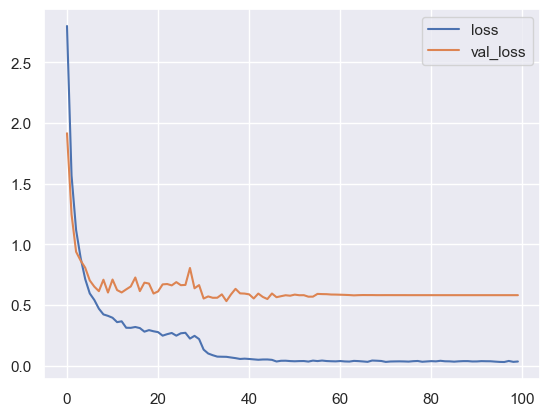

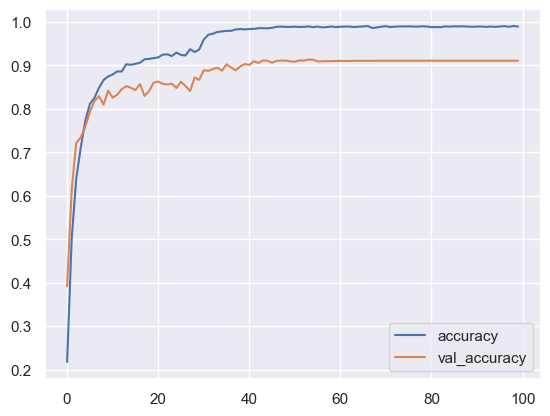

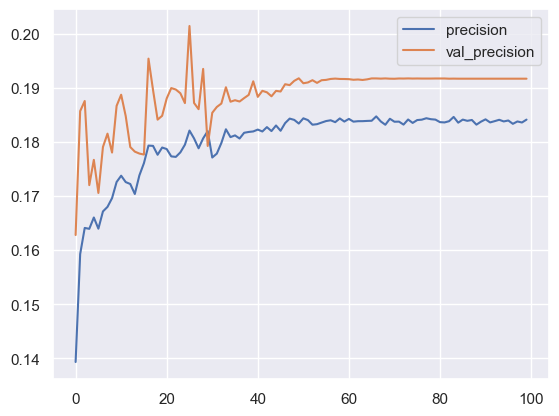

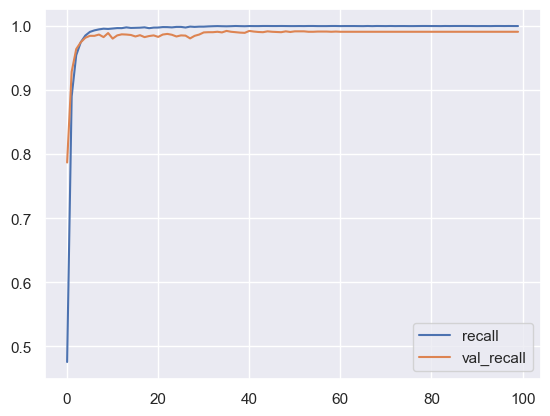

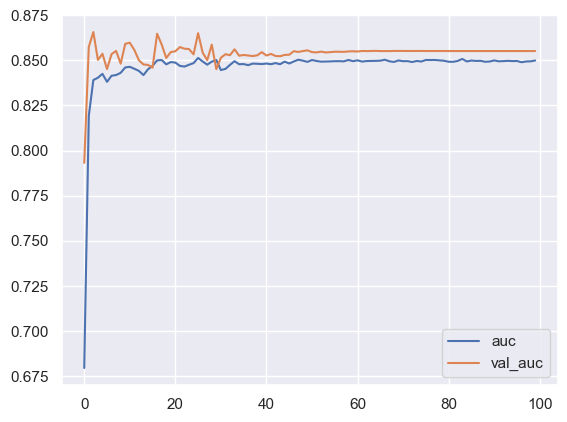

In [29]:
for i in range(5):
    history31_df.iloc[:,[i,i+5]].plot()

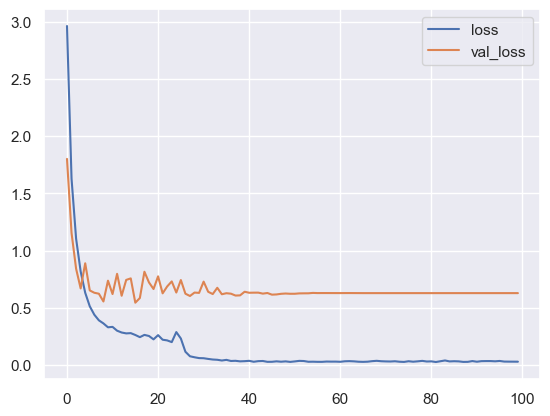

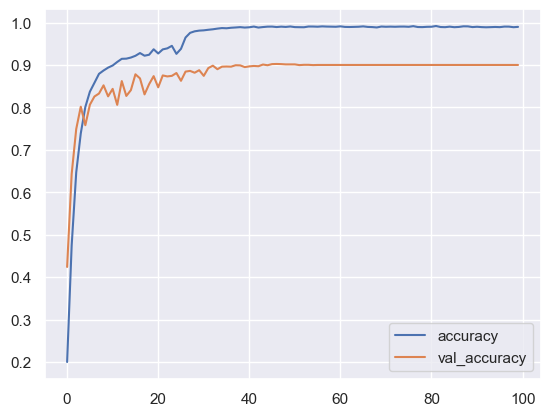

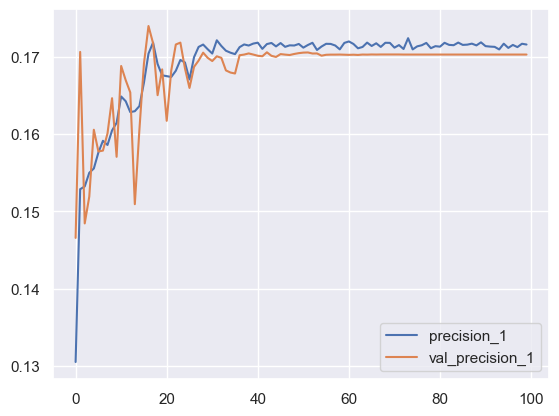

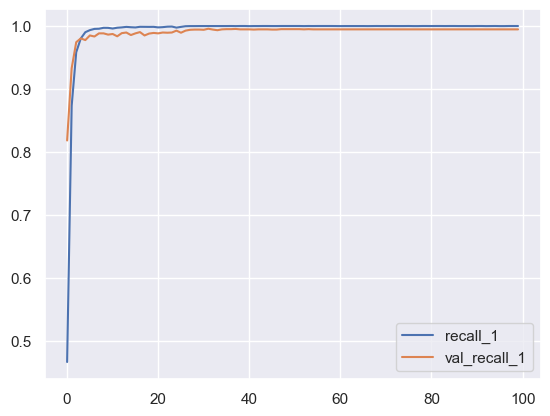

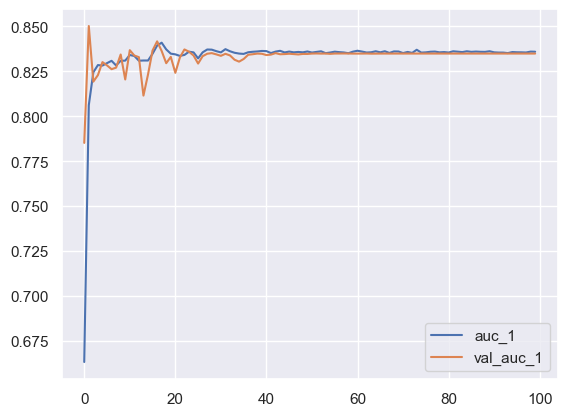

In [30]:
for i in range(5):
    history31v2_df.iloc[:,[i,i+5]].plot()

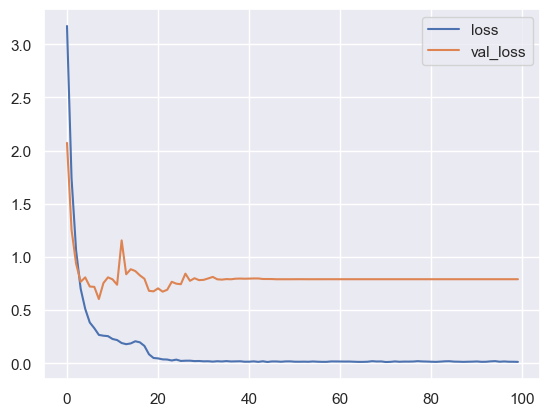

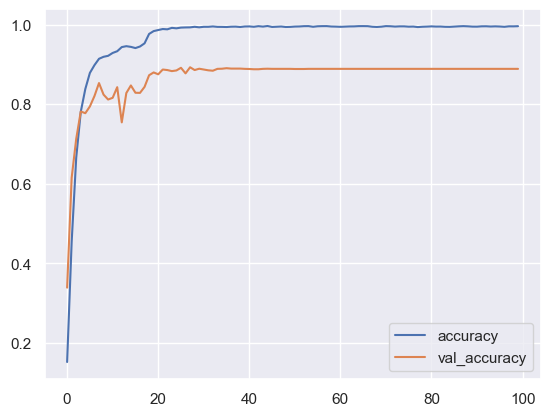

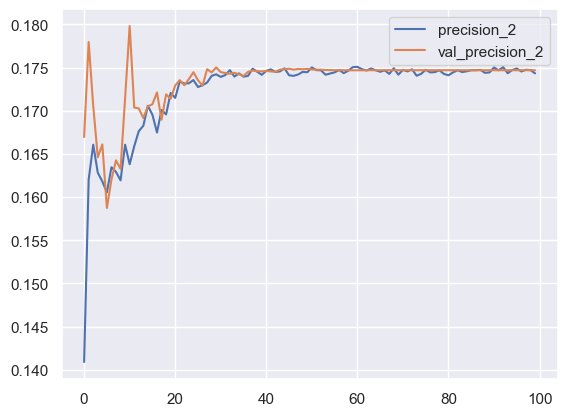

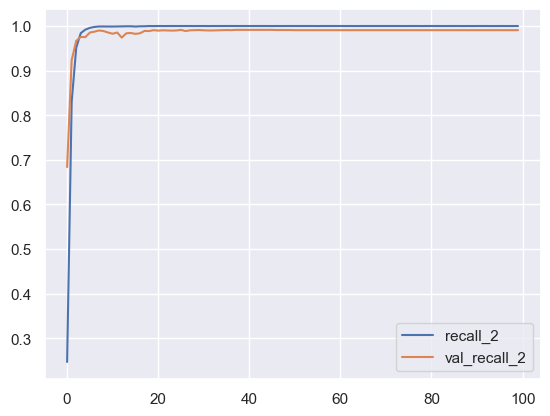

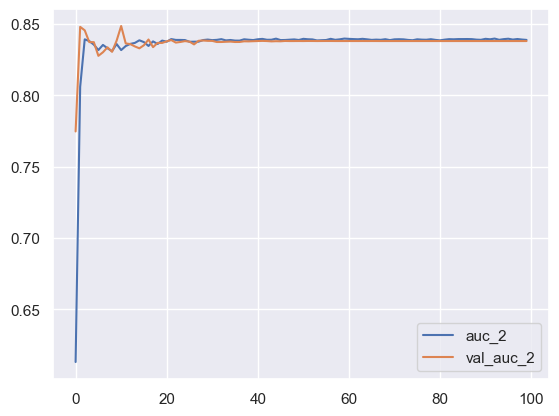

In [31]:
for i in range(5):
    history31_cc_df.iloc[:,[i,i+5]].plot()

## Model Testing

### Model31

In [32]:
test_results31 = get_results(
    lambda: get_model(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr),
    test31_ds,
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_best-{model_format}.h5',
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_last-{model_format}.h5'
    )

test_results31

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 31, 31, 256)       2560      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 256)      0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 15, 15, 256)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 15, 15, 256)       590080    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 256)        0         
 2D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 7, 7, 256)        

,loss,acc,precision,recall,auc
best,0.528454,0.896000,0.186251,0.990667,0.852143
last,0.589442,0.902333,0.189729,0.991333,0.853805


### Model31V2

In [71]:
test_results31v2 = get_results(
    lambda: get_modelv2(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr),
    test31_ds,
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_best-{model_format}.h5',
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_last-{model_format}.h5'
    )

test_results31v2

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_165 (Conv2D)         (None, 31, 31, 64)        640       
                                                                 
 batch_normalization_41 (Bat  (None, 31, 31, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_142 (MaxPooli  (None, 15, 15, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_215 (Dropout)       (None, 15, 15, 64)        0         
                                                                 
 conv2d_166 (Conv2D)         (None, 15, 15, 128)       73856     
                                                                 
 batch_normalization_42 (Bat  (None, 15, 15, 128)    

,loss,acc,precision,recall,auc
best,0.166306,0.955,0.180689,0.999333,0.855333
last,0.177651,0.953,0.180461,0.999333,0.854715


### Model31_CC

In [34]:
test_results31_cc = get_results(
    lambda: get_model_cc(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr),
    test31_ds,
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_best-{model_format}.h5',
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_last-{model_format}.h5'
    )

test_results31_cc

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 31, 31, 64)        640       
                                                                 
 dropout_29 (Dropout)        (None, 31, 31, 64)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 31, 31, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 15, 15, 128)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 15, 15, 256)       295168    
                                                      

,loss,acc,precision,recall,auc
best,0.595376,0.849667,0.163830,0.985000,0.832088
last,0.682371,0.888000,0.173452,0.991333,0.836715


In [150]:
test_results31_aug_cc = get_results(
    lambda: get_model_cc(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr),
    make_dataset(f'test-aug-128/{class_size}/', img_size, batch_size),
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_best-{model_format}.h5',
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_last-{model_format}.h5',
    )

test_results31_aug_cc

Found 15000 files belonging to 15 classes.
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_86 (Conv2D)          (None, 31, 31, 64)        640       
                                                                 
 dropout_112 (Dropout)       (None, 31, 31, 64)        0         
                                                                 
 conv2d_87 (Conv2D)          (None, 31, 31, 128)       73856     
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 dropout_113 (Dropout)       (None, 15, 15, 128)       0         
                                                                 
 conv2d_88 (Conv2D)          (None, 15, 15, 256)       295168    
          

,loss,acc,precision,recall,auc
best,0.568986,0.854667,0.146742,0.993,0.806719
last,0.579006,0.853000,0.147592,0.993,0.807378


### Result Compilation

In [82]:
with os.scandir(f'./model_checkpoints/1000/img{img_size}') as dir:
    checkpoint_dict = {}
    flag = 0
    for entry in dir:
        checkpoint = entry.name[:-3].split('-')
        model, cp_conv_nodes, cp_dense_nodes, cp_dropout, cp_batch_size, cp_epochs = checkpoint
        model = model[:-5]
        if model=='model31':
            model = lambda:get_model(int(cp_conv_nodes), int(cp_dense_nodes), kernel, stride, img_size, 'relu', float(cp_dropout), lr, summary=False)
        elif model=='model31v2':
            model = lambda:get_modelv2(int(cp_conv_nodes), int(cp_dense_nodes), kernel, stride, img_size, 'relu', float(cp_dropout), lr, summary=False)
        elif model=='model31_cc':
            model = lambda:get_model_cc(int(cp_conv_nodes), int(cp_dense_nodes), kernel, stride, img_size, 'relu', float(cp_dropout), lr, summary=False)
        else:
            continue

        try:
            if not flag:
                flag = 1
                compiled_results31 = get_results(model, test31_ds, f'./model_checkpoints/{class_size}/img{img_size}/{entry.name}', checkpoint=entry.name)
            else:
                compiled_results31 = pd.concat((compiled_results31, get_results(model, test31_ds, f'./model_checkpoints/{class_size}/img{img_size}/{entry.name}', checkpoint=entry.name)))
        except:
            pass
    
display(compiled_results31)

94/94 [==============================] - 1s 9ms/step - loss: 0.3716 - accuracy: 0.8933 - precision_87: 0.1334 - recall_87: 0.9920 - auc_87: 0.7777


,loss,acc,precision,recall,auc
model31v2_best-256-256-0.2-32-100.h5,0.188102,0.957333,0.170886,0.999000,0.845355
model31v2_best-256-256-0.3-32-100.h5,0.166306,0.955000,0.180689,0.999333,0.855333
model31v2_last-256-256-0.2-32-100.h5,0.198256,0.957667,0.172820,0.998667,0.845941
model31v2_last-256-256-0.3-32-100.h5,0.177651,0.953000,0.180461,0.999333,0.854715
model31_best-256-256-0.2-32-100.h5,0.528454,0.896000,0.186251,0.990667,0.852143
model31_best-256-256-0.4-32-100.h5,0.359459,0.900333,0.134062,0.993000,0.780185
model31_cc_best-256-256-0.3-32-100.h5,0.182299,0.959667,0.173661,1.000000,0.846811
model31_cc_last-256-256-0.3-32-100.h5,0.189230,0.956667,0.175193,1.000000,0.847678
model31_last-256-256-0.2-32-100.h5,0.589442,0.902333,0.189729,0.991333,0.853805
model31_last-256-256-0.4-32-100.h5,0.371599,0.893333,0.133423,0.992000,0.777669


In [83]:
top2 = compiled_results31.sort_values(by=['acc'], ascending=False)[:2]
display(top2)
if not os.path.exists('./model_checkpoints/best_checkpoints/'):
    os.mkdir('./model_checkpoints/best_checkpoints/')

for top_model_fp in top2.index.to_list():
    shutil.copy2(f'./model_checkpoints/1000/img{img_size}/{top_model_fp}', f'./model_checkpoints/best_checkpoints/{top_model_fp}')

,loss,acc,precision,recall,auc
model31_cc_best-256-256-0.3-32-100.h5,0.182299,0.959667,0.173661,1.000000,0.846811
model31v2_last-256-256-0.2-32-100.h5,0.198256,0.957667,0.172820,0.998667,0.845941


In [ ]:
X_validation, y_validation = [],[]
for x,y in train31_ds:
    X_validation.extend(x.numpy().tolist())
    y_validation.extend(y.numpy().tolist())

X_validation, y_validation = np.array(X_validation), np.array(y_validation)

print(X_validation.shape, y_validation.shape)

## Hyperparamter Tuning


In [274]:
X_train, y_train = [],[]
for x,y in train31_ds:
    X_train.extend(x.numpy().tolist())
    y_train.extend(y.numpy().tolist())

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape, y_train.shape)

(9028, 31, 31, 1) (9028, 15)


In [276]:
params = {
    'activation': ['relu','leaky_relu','tanh'],
    'kernel': [3],
    'stride':[1],
    'lr':[1e-3,1e-4,1e-5],
    'img_size':[img_size],
    'conv_nodes':[256],
    'dense_nodes':[256],
    'dropout':np.arange(0.4,0.51,0.02),
    'summary':[False]
}

make_df = lambda cv: pd.DataFrame({'best':[cv.best_score_], 'params':[cv.best_params_]})

with os.scandir(f'./model_checkpoints/best_checkpoints') as dir:
    flag = 0
    for entry in dir:
        checkpoint = entry.name[:-3].split('-')
        model, cp_conv_nodes, cp_dense_nodes, cp_dropout, cp_batch_size, cp_epochs = checkpoint
        model = model[:-5]
        if model=='model31':
            model = get_model
        elif model=='model31v2':
            model = get_modelv2
        elif model=='model31_cc':
            model = get_model_cc
        else:
            continue

    cv = RandomizedSearchCV(KerasClassifier(model), params, cv=4)
    cv.fit(X_train[:3000], y_train[:3000])

    print(f'\n\nBest Acc: {cv.best_score_}, params: {cv.best_params_}')

C:\Users\linco\AppData\Local\Temp\ipykernel_20408\1471603719.py:30: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  cv = RandomizedSearchCV(KerasClassifier(model), params, cv=4)


94/94 [==============================] - 2s 8ms/step - loss: 3.0378 - accuracy: 0.0853 - precision_217: 0.0789 - recall_217: 0.5390 - auc_217: 0.5570


Best Acc: 0.16499999910593033, params: {'summary': False, 'stride': 1, 'lr': 0.0001, 'kernel': 3, 'img_size': 31, 'dropout': 0.42000000000000004, 'dense_nodes': 256, 'conv_nodes': 256, 'activation': 'tanh'}


In [277]:
#Hyperparameter-tuned model
with tf.device('/GPU:0'):   
    model31v2 = get_modelv2(256, 256, 3, 1, 31, 'tanh', 0.42, 0.0001)
    visualkeras.layered_view(model31).show()
    model31v2_checkpoint = ModelCheckpoint(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_HPT_best-{model_format}.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, save_format='h5')
    history31v2 = model31v2.fit(train_aug31_ds ,validation_data=validation31_ds, epochs=epochs, shuffle=True, callbacks=[model31v2_checkpoint,reducelr])
    model31v2.save_weights(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_HPT_last-{model_format}.h5', save_format='h5', overwrite=True)

Model: "sequential_239"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_713 (Conv2D)         (None, 31, 31, 64)        640       
                                                                 
 max_pooling2d_679 (MaxPooli  (None, 15, 15, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_945 (Dropout)       (None, 15, 15, 64)        0         
                                                                 
 conv2d_714 (Conv2D)         (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_680 (MaxPooli  (None, 7, 7, 128)        0         
 ng2D)                                                           
                                                                 
 dropout_946 (Dropout)       (None, 7, 7, 128)      

In [279]:
test_results31v2_HPT = get_results(
    lambda: get_modelv2(256, 256, 3, 1, 31, 'tanh', 0.42, 0.0001),
    test31_ds,
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_HPT_best-{model_format}.h5',
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_HPT_last-{model_format}.h5'
    )

test_results31v2_HPT

Model: "sequential_242"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_722 (Conv2D)         (None, 31, 31, 64)        640       
                                                                 
 max_pooling2d_688 (MaxPooli  (None, 15, 15, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_957 (Dropout)       (None, 15, 15, 64)        0         
                                                                 
 conv2d_723 (Conv2D)         (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_689 (MaxPooli  (None, 7, 7, 128)        0         
 ng2D)                                                           
                                                                 
 dropout_958 (Dropout)       (None, 7, 7, 128)      

,loss,acc,precision,recall,auc
best,0.631411,0.799333,0.157348,0.994333,0.833785
last,0.695684,0.785667,0.159994,0.995000,0.834258


# Img_size 128

## Dataset

### Dataset Hyperparameter

In [106]:
#Hyper Parameters for Dataset
img_size= 128
batch_size = 64
class_size = 1000


In [107]:
train128_ds = make_dataset('train/', img_size, batch_size)
test128_ds = make_dataset('test/', img_size, batch_size)
validation128_ds = make_dataset('validation/', img_size, batch_size)

for img, labels in train31_ds:
    display(img, labels)
    break

Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


<tf.Tensor: shape=(32, 31, 31, 1), dtype=float32, numpy=
array([[[[ 61.919872 ],
         [155.48619  ],
         [179.84625  ],
         ...,
         [161.78975  ],
         [ 75.29578  ],
         [193.50175  ]],

        [[ 32.309036 ],
         [175.75784  ],
         [184.8918   ],
         ...,
         [ 75.27981  ],
         [151.12306  ],
         [147.62624  ]],

        [[ 52.43939  ],
         [143.13396  ],
         [139.70473  ],
         ...,
         [246.5915   ],
         [246.64572  ],
         [ 94.68505  ]],

        ...,

        [[ 85.53312  ],
         [ 48.56693  ],
         [ 66.185196 ],
         ...,
         [147.03163  ],
         [159.31099  ],
         [ 64.89568  ]],

        [[ 93.31314  ],
         [ 43.627235 ],
         [ 60.63811  ],
         ...,
         [197.1282   ],
         [201.42834  ],
         [169.22758  ]],

        [[ 90.67403  ],
         [ 64.85529  ],
         [ 61.936195 ],
         ...,
         [168.56772  ],
         [ 90.41252

<tf.Tensor: shape=(32, 15), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0

## Data Augmentation + Auto Encoder

### Augmenting dataset to equal class size

In [86]:
create_aug_dataset(class_size, train, f'./train-aug-{img_size}', img_size)
create_aug_dataset(class_size, test, f'./test-aug-{img_size}',  img_size)

Dataset found in device.
Dataset found in device.


In [87]:
train_aug128_ds = make_dataset(f'train-aug-{img_size}/{class_size}/', img_size, batch_size)

Found 15000 files belonging to 15 classes.


### Autoencoder

In [ ]:
'''aug_train31_ds = train31_ds.map(lambda x,y: (data_augmentation(x), y))
ae_aug_train_ds = aug_train_ds.map(lambda x,y: (x,x))

ae_validation128_ds = validation128_ds.map(lambda x,y: (x,x))'''

'aug_train_ds = train_ds.map(lambda x,y: (data_augmentation(x), y))\nae_aug_train_ds = aug_train_ds.map(lambda x,y: (x,x))\n\nae_validation_ds = validation_ds.map(lambda x,y: (x,x))'

In [ ]:
'''for x, xx in ae_aug_train_ds:
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.imshow(x[0], cmap='grey')
    ax2.imshow(xx[0], cmap='grey')
    break'''

"for x, xx in ae_aug_train_ds:\n    fig, (ax1,ax2) = plt.subplots(1,2)\n    ax1.imshow(x[0], cmap='grey')\n    ax2.imshow(xx[0], cmap='grey')\n    break"

In [ ]:
'''autoencoder = Sequential([
    Rescaling(scale=1./255, input_shape=(img_size,img_size,1)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


autoencoder.compile(optimizer = 'adadelta', loss ='binary_crossentropy')
autoencoder.summary()'''

"autoencoder = Sequential([\n    Rescaling(scale=1./255, input_shape=(img_size,img_size,1)),\n    Dense(32, activation='relu'),\n    Dense(1, activation='sigmoid')\n])\n\n\nautoencoder.compile(optimizer = 'adadelta', loss ='binary_crossentropy')\nautoencoder.summary()"

In [ ]:
'''with tf.device('/GPU:0'):
    history_ae = autoencoder.fit(ae_aug_train_ds, validation_data=ae_validation128_ds, shuffle=True, epochs=1)
history_ae_df = pd.DataFrame(history_ae.history)
history_ae_df'''

"with tf.device('/GPU:0'):\n    history_ae = autoencoder.fit(ae_aug_train_ds, validation_data=ae_validation_ds, shuffle=True, epochs=1)\nhistory_ae_df = pd.DataFrame(history_ae.history)\nhistory_ae_df"

In [ ]:
'''for i, (img_batch, _) in enumerate(ae_validation128_ds):
    decoded_img = autoencoder.predict(img_batch)
    for ii in range(10):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(img_batch[ii], cmap='grey')
        ax2.imshow(decoded_img[ii], cmap='grey')

    plt.plot()
    if i==0:
        break
'''

"for i, (img_batch, _) in enumerate(ae_validation_ds):\n    decoded_img = autoencoder.predict(img_batch)\n    for ii in range(10):\n        fig, (ax1, ax2) = plt.subplots(1, 2)\n        ax1.imshow(img_batch[ii], cmap='grey')\n        ax2.imshow(decoded_img[ii], cmap='grey')\n\n    plt.plot()\n    if i==0:\n        break\n"

In [ ]:
'''new_pred, new_y = [], []
for x,y in aug_train_ds:
    new_pred.extend(autoencoder.predict(x))
    new_y.extend(y)

ae_pred_train = tf.data.Dataset.from_tensor_slices((new_pred, new_y)).batch(batch_size)'''

'new_pred, new_y = [], []\nfor x,y in aug_train_ds:\n    new_pred.extend(autoencoder.predict(x))\n    new_y.extend(y)\n\nae_pred_train = tf.data.Dataset.from_tensor_slices((new_pred, new_y)).batch(batch_size)'

In [ ]:
'''for i, (img_batch, y) in enumerate(ae_pred_train):
    for ii in range(10):
        fig, ax1 = plt.subplots(1, 1)
        ax1.imshow(img_batch[ii], cmap='grey')
        fig.suptitle(classes[np.array(y[ii]).astype(bool)])

    break'''

"for i, (img_batch, y) in enumerate(ae_pred_train):\n    for ii in range(10):\n        fig, ax1 = plt.subplots(1, 1)\n        ax1.imshow(img_batch[ii], cmap='grey')\n        fig.suptitle(classes[np.array(y[ii]).astype(bool)])\n\n    break"

## Model Training

In [88]:
#Hyper parameters for model
conv_nodes = 256
dense_nodes = 256

lr = 1e-3
dropout = 0.4
kernel = 3
stride = 2
epochs = 100

model_format = f'{conv_nodes}-{dense_nodes}-{dropout}-{batch_size}-{epochs}'

In [89]:
if not os.path.exists(f'./model_checkpoints/{class_size}'):
    os.mkdir(f'./model_checkpoints/{class_size}')
if not os.path.exists(f'./model_checkpoints/{class_size}/img{img_size}'):
    os.mkdir(f'./model_checkpoints/{class_size}/img{img_size}')

In [90]:
optimizer = Adam(learning_rate=lr)
loss = CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy',Precision(), Recall(), AUC()]

In [91]:
#Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reducelr = ReduceLROnPlateau(monitor='val_loss',patience=10)

### Model128


In [94]:
with tf.device('/GPU:0'):   
    model128 = get_model(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr)
    
    visualkeras.layered_view(model128).show()
    model_checkpoint128 = ModelCheckpoint(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_best-{model_format}.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, save_format='h5')
    history128 = model128.fit(train_aug128_ds ,validation_data=validation128_ds, epochs=epochs, shuffle=True, callbacks=[model_checkpoint128,reducelr])
    model128.save_weights(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_last-{model_format}.h5', save_format='h5', overwrite=True)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 256)       2560      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 256)      0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 32, 32, 256)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 256)       590080    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 256)        0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 8, 8, 256)        

KeyboardInterrupt: 

In [ ]:
history128_df = pd.DataFrame(history128.history)
history128_df


,loss,accuracy,precision_31,recall_31,auc_31,val_loss,val_accuracy,val_precision_31,val_recall_31,val_auc_31,lr
0,3.490182,0.098667,0.097963,0.083667,0.543477,2.639555,0.130667,0.382759,0.037000,0.586137,0.001
1,2.495943,0.177867,0.133700,0.319533,0.651244,2.298678,0.271000,0.196002,0.369333,0.745328,0.001
2,2.286418,0.251600,0.139540,0.566133,0.717769,2.116041,0.353333,0.189141,0.569000,0.792190,0.001
3,2.113851,0.305867,0.139049,0.724333,0.752870,2.000170,0.392667,0.173172,0.653667,0.791561,0.001
4,1.960497,0.366533,0.140259,0.804133,0.773485,1.722545,0.489333,0.172519,0.827000,0.829998,0.001
...,...,...,...,...,...,...,...,...,...,...,...
75,0.335043,0.902000,0.113587,0.998333,0.733700,0.387946,0.906333,0.113925,0.997000,0.737115,0.001
76,0.338236,0.901067,0.112700,0.998733,0.730664,0.596526,0.851333,0.111219,0.993333,0.728214,0.001
77,0.367828,0.893867,0.112778,0.997467,0.731386,0.428730,0.885333,0.114999,0.997000,0.741194,0.001
78,0.347675,0.898800,0.111209,0.998000,0.726792,0.402998,0.893667,0.112649,0.995333,0.733687,0.001


### Model128V2

In [ ]:
with tf.device('/GPU:0'):   
    model128v2 = get_modelv2(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr)
    visualkeras.layered_view(model128).show()
    model_checkpoint128v2 = ModelCheckpoint(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_best-{model_format}.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, save_format='h5')
    history128v2 = model128v2.fit(train_aug128_ds ,validation_data=validation128_ds, epochs=epochs, shuffle=True, callbacks=[model_checkpoint128v2,reducelr])
    model128v2.save_weights(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_last-{model_format}.h5', save_format='h5', overwrite=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 8, 8, 128)        

In [ ]:
history128v2_df = pd.DataFrame(history128v2.history)
history128v2_df


,loss,accuracy,precision_3,recall_3,auc_3,val_loss,val_accuracy,val_precision_3,val_recall_3,val_auc_3
0,3.778617,0.067867,0.067129,0.047067,0.504440,2.707008,0.077667,0.000000,0.000000,0.518007
1,2.635601,0.108800,0.115695,0.137800,0.569522,2.557486,0.172000,0.188222,0.114000,0.687810
2,2.452113,0.160867,0.117965,0.465467,0.667709,2.413055,0.237667,0.165209,0.270667,0.735741
3,2.295994,0.212400,0.123651,0.652400,0.711923,2.144494,0.334667,0.166748,0.686333,0.788754
4,2.125197,0.281333,0.125904,0.781933,0.739094,1.928952,0.390667,0.161235,0.783333,0.799033
5,1.918773,0.358267,0.130910,0.843800,0.761155,1.618325,0.519000,0.163041,0.882000,0.833146
6,1.734869,0.427133,0.134355,0.881200,0.773634,1.352352,0.629333,0.161476,0.926333,0.841629
7,1.570668,0.486400,0.136550,0.905000,0.783837,1.128550,0.655333,0.156255,0.954667,0.837063
8,1.416981,0.535933,0.136394,0.930000,0.789242,1.020421,0.689333,0.152837,0.951667,0.828857
9,1.283675,0.580733,0.139131,0.946733,0.795350,0.971519,0.695667,0.146132,0.962667,0.819561


### Model128_CC

In [92]:
with tf.device('/GPU:0'):   
    model128_cc = get_model_cc(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr)
    visualkeras.layered_view(model128_cc).show()
    model128_cc_checkpoint = ModelCheckpoint(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_best-{model_format}.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, save_format='h5')
    history128_cc = model128_cc.fit(train_aug128_ds ,validation_data=validation128_ds, epochs=epochs, shuffle=True, callbacks=[model128_cc_checkpoint,reducelr])
    model128_cc.save_weights(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_last-{model_format}.h5', save_format='h5', overwrite=True)

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_288 (Conv2D)         (None, 64, 64, 64)        640       
                                                                 
 batch_normalization_141 (Ba  (None, 64, 64, 64)       256       
 tchNormalization)                                               
                                                                 
 dropout_375 (Dropout)       (None, 64, 64, 64)        0         
                                                                 
 conv2d_289 (Conv2D)         (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_142 (Ba  (None, 32, 32, 128)      512       
 tchNormalization)                                               
                                                                 
 max_pooling2d_241 (MaxPooli  (None, 16, 16, 128)    

In [93]:
history128_cc_df = pd.DataFrame(history128_cc.history)
history128_cc_df

,loss,accuracy,precision_89,recall_89,auc_89,val_loss,val_accuracy,val_precision_89,val_recall_89,val_auc_89,lr
0,2.152841,0.362600,0.136615,0.815000,0.756806,1.454928,0.530000,0.160462,0.935333,0.835119,1.000000e-03
1,1.199773,0.617200,0.158503,0.961467,0.834163,1.110558,0.638667,0.148208,0.973333,0.821839,1.000000e-03
2,0.852145,0.730800,0.161636,0.983133,0.842965,1.200556,0.626333,0.165561,0.965333,0.837190,1.000000e-03
3,0.646241,0.794333,0.161926,0.989867,0.844037,0.865319,0.724667,0.154353,0.984000,0.828149,1.000000e-03
4,0.499308,0.838000,0.162430,0.995200,0.845036,0.533198,0.825000,0.156044,0.994000,0.832187,1.000000e-03
...,...,...,...,...,...,...,...,...,...,...,...
95,0.018443,0.994267,0.165826,1.000000,0.839395,0.148160,0.956333,0.172622,1.000000,0.848048,1.000000e-10
96,0.016585,0.995467,0.166087,1.000000,0.839624,0.147273,0.956000,0.172692,1.000000,0.848131,1.000000e-10
97,0.019809,0.994867,0.165779,1.000000,0.839238,0.147506,0.956333,0.172801,1.000000,0.848262,1.000000e-10
98,0.019336,0.994333,0.165680,1.000000,0.838890,0.148376,0.956667,0.172781,1.000000,0.847793,1.000000e-10


### Val_acc comparison

In [ ]:
history128_df.iloc[[history128_df['val_accuracy'].argmax()]]

In [ ]:
history128v2_df.iloc[[history128v2_df['val_accuracy'].argmax()]]

,loss,accuracy,precision_3,recall_3,auc_3,val_loss,val_accuracy,val_precision_3,val_recall_3,val_auc_3
29,0.510508,0.839467,0.131815,0.9948,0.780376,0.574704,0.827333,0.132041,0.99,0.785109


In [108]:
history128_cc_df.iloc[[history128_cc_df['val_accuracy'].argmax()]]

,loss,accuracy,precision_89,recall_89,auc_89,val_loss,val_accuracy,val_precision_89,val_recall_89,val_auc_89,lr
34,0.02939,0.990333,0.165044,1.0,0.83884,0.138689,0.958333,0.170485,0.999667,0.846935,0.0001


### plots

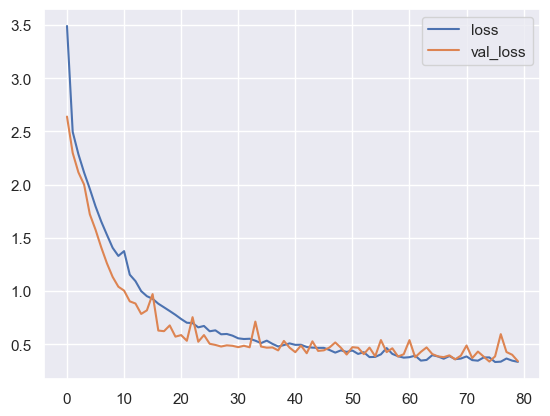

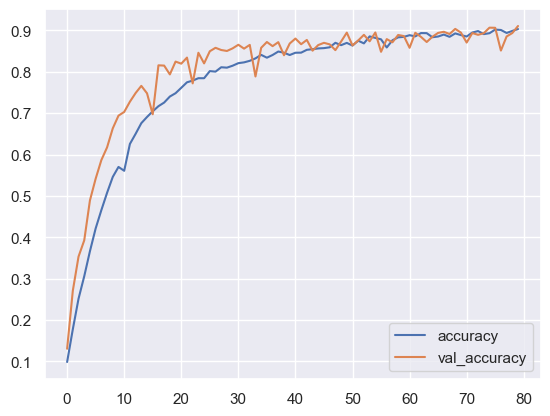

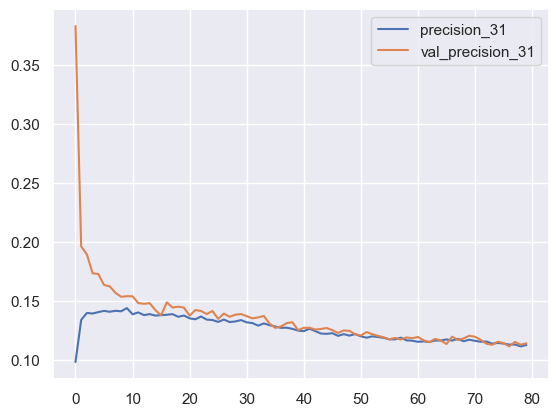

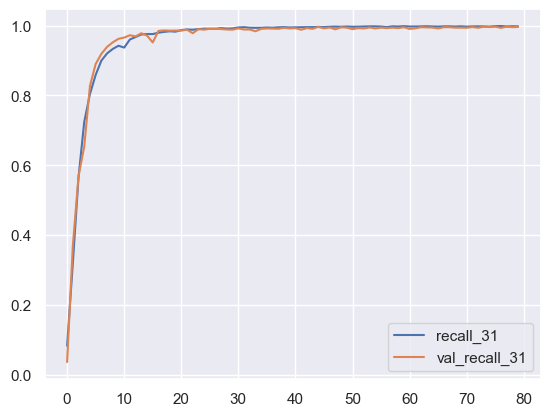

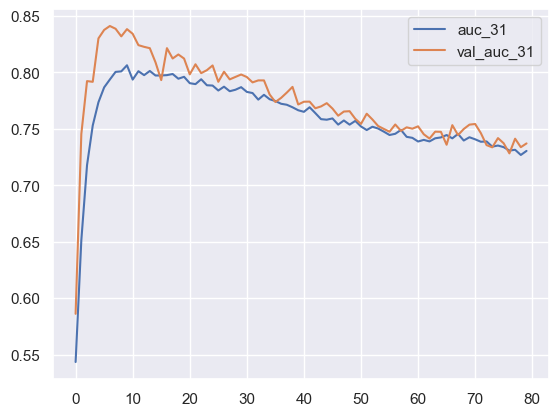

In [ ]:
for i in range(5):
    history128_df.iloc[:,[i,i+5]].plot()

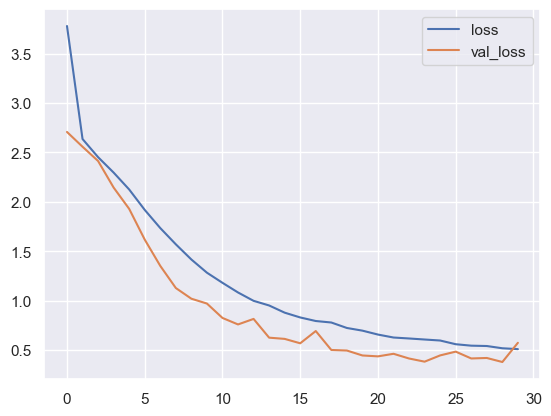

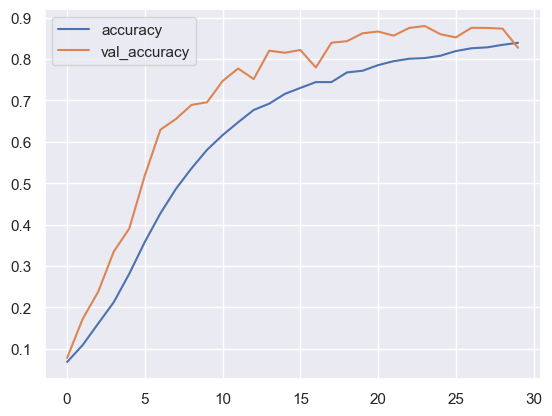

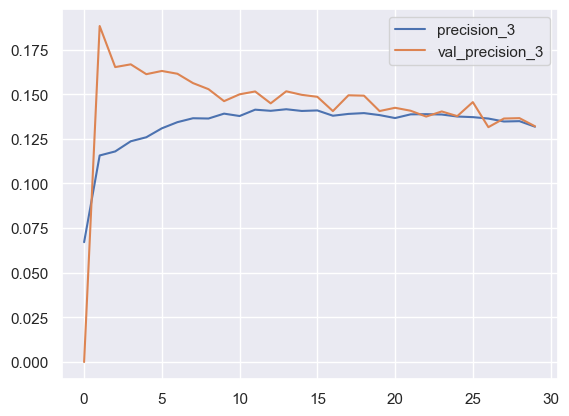

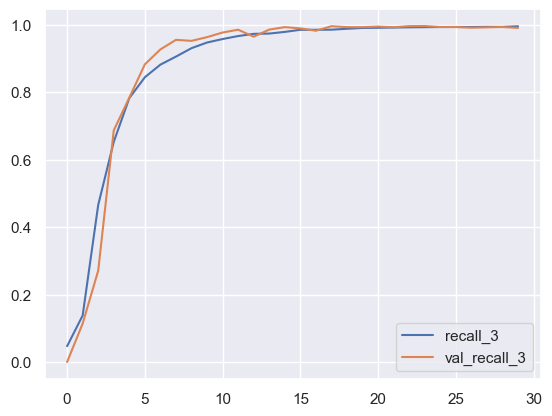

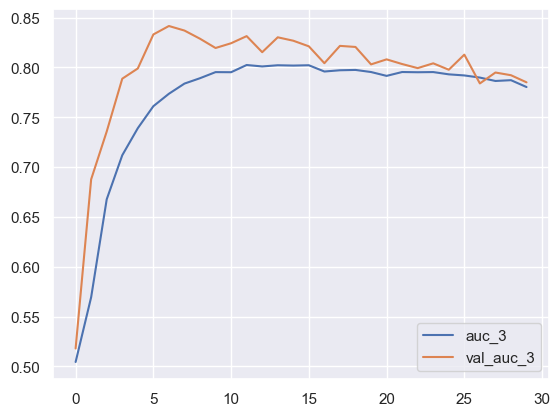

In [ ]:
for i in range(5):
    history128v2_df.iloc[:,[i,i+5]].plot()

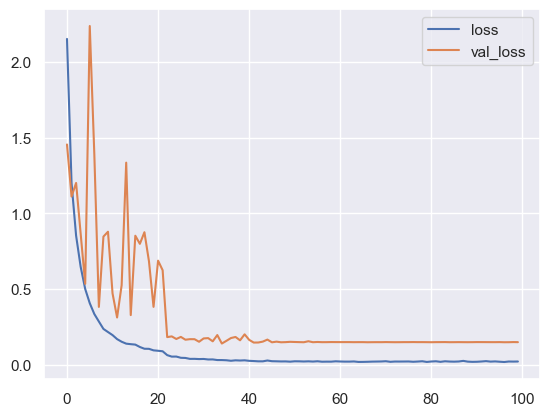

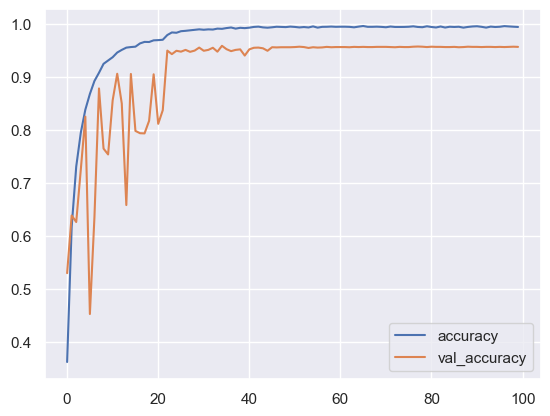

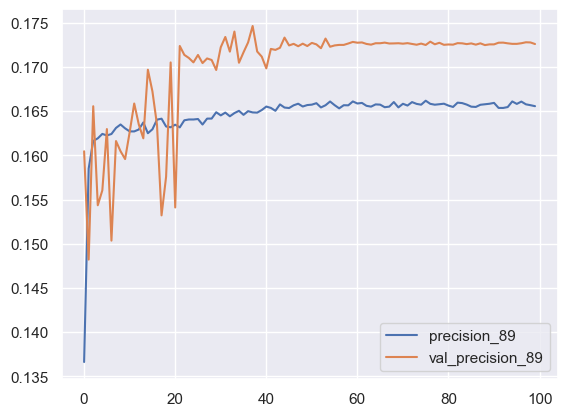

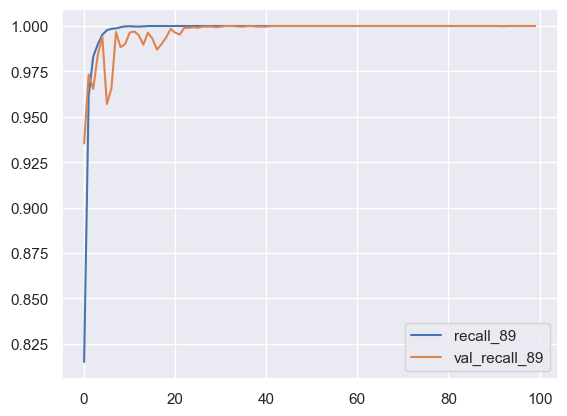

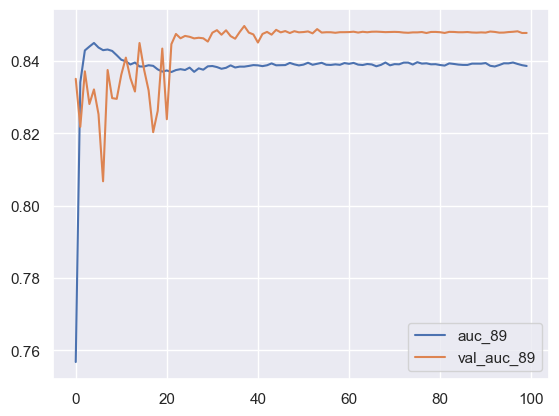

In [95]:
for i in range(5):
    history128_cc_df.iloc[:,[i,i+5]].plot()

## Model Testing

### Model128

In [ ]:
test_results128 = get_results(
    lambda: get_model(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr),
    test128_ds,
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_best-{model_format}.h5',
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_last-{model_format}.h5'
    )

test_results128

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 64, 64, 256)       2560      
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 32, 32, 256)      0         
 g2D)                                                            
                                                                 
 dropout_88 (Dropout)        (None, 32, 32, 256)       0         
                                                                 
 conv2d_82 (Conv2D)          (None, 16, 16, 256)       590080    
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 8, 8, 256)        0         
 g2D)                                                            
                                                                 
 dropout_89 (Dropout)        (None, 8, 8, 256)       

,loss,acc,precision,recall,auc
best,0.355054,0.901667,0.115048,0.994667,0.742123
last,0.353901,0.909000,0.113990,0.995667,0.737140


### Model128V2

In [ ]:
test_results128v2 = get_results(
    lambda: get_modelv2(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr),
    test128_ds,
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_best-{model_format}.h5',
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_last-{model_format}.h5'
    )

test_results128v2

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_87 (Conv2D)          (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 dropout_96 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_88 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 dropout_97 (Dropout)        (None, 8, 8, 128)       

,loss,acc,precision,recall,auc
best,0.347490,0.882000,0.137516,0.994333,0.795527
last,0.530429,0.836667,0.132444,0.989000,0.785400


### Model128_CC

In [96]:
test_results128_cc = get_results(
    lambda: get_model_cc(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr),
    test128_ds,
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_best-{model_format}.h5',
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_last-{model_format}.h5'
    )

test_results128_cc

Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_292 (Conv2D)         (None, 64, 64, 64)        640       
                                                                 
 batch_normalization_146 (Ba  (None, 64, 64, 64)       256       
 tchNormalization)                                               
                                                                 
 dropout_380 (Dropout)       (None, 64, 64, 64)        0         
                                                                 
 conv2d_293 (Conv2D)         (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_147 (Ba  (None, 32, 32, 128)      512       
 tchNormalization)                                               
                                                                 
 max_pooling2d_243 (MaxPooli  (None, 16, 16, 128)    

,loss,acc,precision,recall,auc
best,0.138496,0.959333,0.169723,0.999667,0.845534
last,0.145318,0.958333,0.171825,0.999333,0.846352


In [104]:
test_results128_aug_cc = get_results(
    lambda: get_model_cc(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr),
    make_dataset(f'test-aug-128/{class_size}/', img_size, batch_size),
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_best-{model_format}.h5',
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_last-{model_format}.h5',
    )

test_results128_aug_cc

Found 15000 files belonging to 15 classes.
Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_323 (Conv2D)         (None, 64, 64, 64)        640       
                                                                 
 batch_normalization_186 (Ba  (None, 64, 64, 64)       256       
 tchNormalization)                                               
                                                                 
 dropout_420 (Dropout)       (None, 64, 64, 64)        0         
                                                                 
 conv2d_324 (Conv2D)         (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_187 (Ba  (None, 32, 32, 128)      512       
 tchNormalization)                                               
                                                                 
 max_pool

,loss,acc,precision,recall,auc
best,0.141448,0.958000,0.170195,0.999667,0.845415
last,0.148615,0.955333,0.172299,0.999333,0.847554


### Result Compilation

In [109]:
with os.scandir(f'./model_checkpoints/1000/img{img_size}') as dir:
    checkpoint_dict = {}
    flag = 0
    for entry in dir:
        checkpoint = entry.name[:-3].split('-')
        model, cp_conv_nodes, cp_dense_nodes, cp_dropout, cp_batch_size, cp_epochs = checkpoint
        model = model[:-5]
        if model=='model128':
            model = lambda:get_model(int(cp_conv_nodes), int(cp_dense_nodes), kernel, stride, img_size, 'relu', float(cp_dropout), lr, summary=False)
        elif model=='model128v2':
            model = lambda:get_modelv2(int(cp_conv_nodes), int(cp_dense_nodes), kernel, stride, img_size, 'relu', float(cp_dropout), lr, summary=False)
        elif model=='model128_cc':
            model = lambda:get_model_cc(int(cp_conv_nodes), int(cp_dense_nodes), kernel, stride, img_size, 'relu', float(cp_dropout), lr, summary=False)
        else:
            continue
        
        try:
            if not flag:
                flag = 1
                compiled_results = get_results(model, test128_ds, f'./model_checkpoints/{class_size}/img{img_size}/{entry.name}', checkpoint=entry.name)
            else:
                compiled_results = pd.concat((compiled_results, get_results(model, test128_ds, f'./model_checkpoints/{class_size}/img{img_size}/{entry.name}', checkpoint=entry.name)))
        except:
            pass
    
display(compiled_results)

NameError: name 'compiled_results' is not defined

In [ ]:
top2 = compiled_results.sort_values(by=['acc'], ascending=False)[:2]
display(top2)
if not os.path.exists('./model_checkpoints/best_checkpoints/'):
    os.mkdir('./model_checkpoints/best_checkpoints/')

for top_model_fp in top2.index.to_list():
    shutil.copy2(f'./model_checkpoints/1000/img{img_size}{top_model_fp}', f'./model_checkpoints/best_checkpoints/{top_model_fp}')

,loss,acc,precision,recall,auc
model128_cc_last-256-256-0.4-64-100.h5,0.237833,0.935000,0.124662,0.998667,0.761183
model128_cc_best-256-256-0.4-64-100.h5,0.238846,0.934333,0.124496,0.998333,0.760524


## Hyperparameter Tuning

In [293]:
X_train, y_train = [],[]
for i, (x,y) in enumerate(train128_ds):
    X_train.extend(x.numpy().tolist())
    y_train.extend(y.numpy().tolist())
    if i == 100-1:
        break

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape, y_train.shape)

(6400, 128, 128, 1) (6400, 15)


In [ ]:
params = {
    'activation': ['relu','leaky_relu','tanh'],
    'kernel': [3],
    'stride':[2],
    'lr':[1e-3,1e-4,1e-5],
    'img_size':[img_size],
    'conv_nodes':[256],
    'dense_nodes':[256],
    'dropout':np.arange(0.4,0.51,0.02),
    'summary':[False]
}

make_df = lambda cv: pd.DataFrame({'best':[cv.best_score_], 'params':[cv.best_params_]})

cv = RandomizedSearchCV(KerasClassifier(get_model_cc), params, cv=4)
cv.fit(X_train[:3000], y_train[:3000])

print(f'\n\nBest Acc: {cv.best_score_}, params: {cv.best_params_}')

In [ ]:
#Hyperparameter-tuned model
with tf.device('/GPU:0'):   
    model128v2 = get_modelv2(256, 256, 3, 1, 31, 'tanh', 0.42, 0.0001)
    visualkeras.layered_view(model128v2).show()
    model128v2_checkpoint = ModelCheckpoint(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_HPT_best-{model_format}.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, save_format='h5')
    history128v2 = model128v2.fit(train_aug128_ds ,validation_data=validation128_ds, epochs=epochs, shuffle=True, callbacks=[model128v2_checkpoint,reducelr])
    model128v2.save_weights(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_HPT_last-{model_format}.h5', save_format='h5', overwrite=True)